In [1]:
from sagemaker import get_execution_role
role = get_execution_role()

In [ ]:
bucket = 'sagemaker-seanv507' # Use the name of your s3 bucket here

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 786 ms, sys: 316 ms, total: 1.1 s
Wall time: 11.9 s


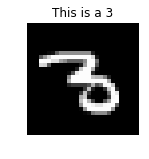

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))


In [7]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3


data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)


# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

CPU times: user 8.66 s, sys: 261 ms, total: 8.92 s
Wall time: 10.5 s


In [9]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3


data_key = 'kmeans_lowlevel_example/data-test'
data_location = 's3://{}/{}'.format(bucket, data_key)


# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, test_set[0], test_set[1])
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

CPU times: user 1.76 s, sys: 22.7 ms, total: 1.78 s
Wall time: 2.2 s


## High level

In [ ]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_highlevel_example/output'.format(bucket)

# print('training data will be uploaded to: {}'.format(data_location))
# print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

In [ ]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

## Low level

In [8]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'kmeans-lowlevel-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

from sagemaker.amazon.amazon_estimator import get_image_uri
image = get_image_uri(boto3.Session().region_name, 'kmeans')

output_location = 's3://{}/kmeans_lowlevel_example/output'.format(bucket)
# print('training artifacts will be uploaded to: {}'.format(output_location))

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 2,
        "InstanceType": "ml.c4.8xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "k": "10",
        "feature_dim": "784",
        "mini_batch_size": "500"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": data_location,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}


sagemaker = boto3.client('sagemaker')

sagemaker.create_training_job(**create_training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')


Training job kmeans-lowlevel-2018-12-20-18-40-56
InProgress
Training job ended with status: Completed
CPU times: user 75.7 ms, sys: 8.33 ms, total: 84 ms
Wall time: 4min


In [ ]:

import boto3
import sagemaker
import json

input_key = 'kmeans_batch_example/input/valid-data.csv'
output_key = 'kmeans_batch_example/output/valid-data.csv.out'
input_location = 's3://{}/{}'.format(bucket, input_key)
output_location = 's3://{}/kmeans_batch_example/output'.format(bucket)

### Convert the validation set numpy array to a csv file and upload to s3
numpy.savetxt('valid-data.csv', valid_set[0], delimiter=',', fmt='%g')
s3_client = boto3.client('s3')
s3_client.upload_file('valid-data.csv', bucket, input_key)

# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path=output_location
    )
# To start a transform job:
transformer.transform(input_location, content_type='text/csv', split_type='Line')
# Then wait until transform job is completed
transformer.wait()

# To fetch validation result 
s3_client.download_file(bucket, output_key, 'valid-result')
with open('valid-result') as f:
    results = f.readlines()   
print("Sample transform result: {}".format(results[0]))

        

In [16]:
sagemaker.__dict__

{'__name__': 'sagemaker',
 '__doc__': None,
 '__package__': 'sagemaker',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7ffa042ddcc0>,
 '__spec__': ModuleSpec(name='sagemaker', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7ffa042ddcc0>, origin='/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/__init__.py', submodule_search_locations=['/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker']),
 '__path__': ['/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker'],
 '__file__': '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/__init__.py',
 '__cached__': '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/__pycache__/__init__.cpython-36.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '_

In [20]:
type(sagemaker)

module

In [21]:
%%time
import boto3
from time import gmtime, strftime


model_name = job_name
print(model_name)
sagemaker = boto3.client('sagemaker')  #clash with module name
info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': image,
    'ModelDataUrl': model_data
}

create_model_response = sagemaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

kmeans-lowlevel-2018-12-20-18-40-56
arn:aws:sagemaker:eu-central-1:710551559883:model/kmeans-lowlevel-2018-12-20-18-40-56
CPU times: user 22.9 ms, sys: 103 µs, total: 23 ms
Wall time: 364 ms


In [23]:

import boto3
import sagemaker
import json
import time
from urllib.parse import urlparse
from time import gmtime, strftime

batch_job_name = 'Batch-Transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
input_location = 's3://{}/kmeans_batch_example/input'.format(bucket)
output_location = 's3://{}/kmeans_batch_example/output'.format(bucket)

### Convert the validation set numpy array to a csv file and upload to s3
numpy.savetxt('valid-data.csv', valid_set[0], delimiter=',', fmt='%g')
s3_client = boto3.client('s3')
input_key = "{}/valid_data.csv".format(urlparse(input_location).path.lstrip('/'))
s3_client.upload_file('valid-data.csv', bucket, input_key)

### Create a transform job
sm = boto3.client('sagemaker')

request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 4,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "MultiRecord",
    "TransformOutput": {
        "S3OutputPath": output_location
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": input_location 
            }
        },
        "ContentType": "text/csv",
        "SplitType": "Line",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

sm.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

### Wait until job completion
while(True):
    response = sm.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if  status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    print("Transform job is still in status: " + status)    
    time.sleep(30)    

### Fetch transform output
output_key = "{}/valid_data.csv.out".format(urlparse(output_location).path.lstrip('/'))
s3_client.download_file(bucket, output_key, 'valid-result')
with open('valid-result') as f:
    results = f.readlines()   
print("Sample transform result: {}".format(results[0]))

                        

Created Transform job with name:  Batch-Transform-2018-12-20-19-52-38
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job ended with status: Completed
Sample transform result: {"closest_cluster":6.0,"distance_to_cluster":5.865166187286377}



In [24]:
!git status

On branch master
Your branch is up-to-date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	./

nothing added to commit but untracked files present (use "git add" to track)


In [25]:
!git ls

git: 'ls' is not a git command. See 'git --help'.

The most similar command is
	log


In [26]:
!ls

mnist.ipynb  mnist.pkl.gz  Untitled.ipynb  valid-data.csv  valid-result


In [ ]:
!git add mnist.ipynb